In [22]:
# Street food image calssifier - EDA Notebook
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("cuDNN version:", torch.backends.cudnn.version())
print("Device count:", torch.cuda.device_count())

if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))

if torch.cuda.is_available():
    device_id = 0  # usually 0 if you have one GPU
    total_mem = torch.cuda.get_device_properties(device_id).total_memory
    print(f"Total GPU memory: {total_mem / (1024**3):.2f} GB")

    reserved_mem = torch.cuda.memory_reserved(device_id)
    allocated_mem = torch.cuda.memory_allocated(device_id)
    print(f"Currently Reserved: {reserved_mem / (1024**3):.2f} GB")
    print(f"Currently Allocated: {allocated_mem / (1024**3):.2f} GB")



PyTorch version: 2.7.1+cu126
CUDA available: True
CUDA version: 12.6
cuDNN version: 90501
Device count: 1
GPU Name: NVIDIA GeForce RTX 2080
Total GPU memory: 8.00 GB
Currently Reserved: 0.38 GB
Currently Allocated: 0.21 GB


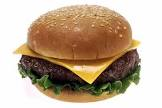

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=162x108 at 0x7C0B232DC410>


In [23]:
from PIL import Image
im = Image.open('../data/train_images/burger/0003_burger.jpg')
im.show()
print(im)
### so we see that the images are RGB and are 162x108

In [38]:
from torchvision import transforms
from torch.utils.data import random_split

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.75, 1.333)),
    transforms.RandomGrayscale(p=0.1),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1 ), scale=(0.9, 1.1)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5, fill=0),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value='random'),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

img_tensor = transform(im)
print(img_tensor.shape)  

# Load dataset of differnet food classes
full_dataset = datasets.ImageFolder("../data/train_images", transform=transform)
train_loader = DataLoader(full_dataset, batch_size=32, shuffle=True)
print("Classes:", full_dataset.classes)
print("Total images:", len(full_dataset))

# Split sizes
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}")

torch.Size([3, 224, 224])
Classes: ['burger', 'churros', 'crepes', 'falafel', 'hot_dog', 'pad_thai', 'pani_puri', 'pretzel', 'shawarma', 'tacos']
Total images: 1520
Train size: 1216, Val size: 304


In [45]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()

        # 1st convolution layer: 3 input channels (RGB), 32 output filters
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)

        # Pooling layer: halves the spatial dimensions
        self.pool = nn.MaxPool2d(2, 2)

        # 2nd convolution layer: 32 input channels, 64 output filters
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)

        # 3rd convolution layer: 64 input channels, 128 output filters
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)

        # Fully connected layer (after flattening)
        self.fc1 = nn.Linear(128 * 28 * 28, 256)  
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  #1st Conv - ReLU - Pool
        x = self.pool(F.relu(self.conv2(x)))  #2nd Conv - ReLU - Pool
        x = self.pool(F.relu(self.conv3(x)))  #3rd Conv - ReLU - Pool
        x = x.view(x.size(0), -1)  # Flatten to 1D
        x = F.relu(self.fc1(x))    # Dense layer
        x = self.fc2(x)            # Output layer
        return x

***Let's initialize the CNN***

In [46]:
# Initialize model
device = torch.device("cuda")
model = CNN(num_classes=len(full_dataset.classes)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

***Let's train the CNN***

In [ ]:
epochs = 10

train_loss_list, train_acc_list = [], []
val_loss_list, val_acc_list = [], []

for epoch in range(epochs):
    # TRAINING
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()
    
    train_acc = 100 * train_correct / train_total

    # VALIDATION
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()
    
    val_acc = 100 * val_correct / val_total

    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Train Loss: {train_loss/len(train_loader):.4f}, "
          f"Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss/len(val_loader):.4f}, "
          f"Val Acc: {val_acc:.2f}%")
    train_loss_list.append(train_loss / len(train_loader))
    train_acc_list.append(train_acc)
    val_loss_list.append(val_loss / len(val_loader))
    val_acc_list.append(val_acc)

# Save the model
torch.save(model.state_dict(), "../CNN_models/complex_transforms_cnn.pth")


Epoch [1/10] Train Loss: 2.8546, Train Acc: 11.18% | Val Loss: 2.3005, Val Acc: 9.87%
Epoch [2/10] Train Loss: 2.2979, Train Acc: 11.51% | Val Loss: 2.3032, Val Acc: 9.21%
Epoch [3/10] Train Loss: 2.2874, Train Acc: 12.42% | Val Loss: 2.2834, Val Acc: 11.51%
Epoch [4/10] Train Loss: 2.2783, Train Acc: 13.65% | Val Loss: 2.2814, Val Acc: 10.86%
Epoch [5/10] Train Loss: 2.2827, Train Acc: 14.47% | Val Loss: 2.2804, Val Acc: 13.16%
Epoch [6/10] Train Loss: 2.2687, Train Acc: 15.30% | Val Loss: 2.2999, Val Acc: 10.20%
Epoch [7/10] Train Loss: 2.2590, Train Acc: 15.95% | Val Loss: 2.2725, Val Acc: 12.83%


***Let's load the testing data now and see hwo we have done***

In [32]:
# Load the mdoel
model.load_state_dict(torch.load("../CNN_models/simple_cnn.pth"))
model.eval()

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=200704, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

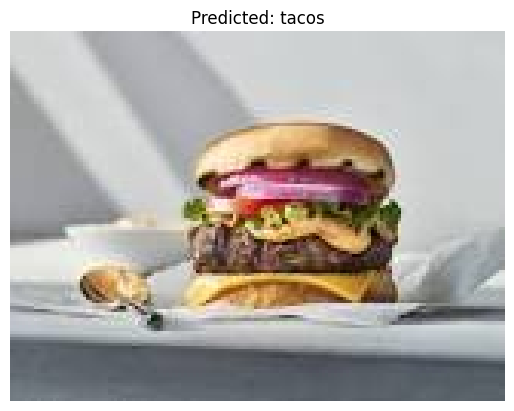

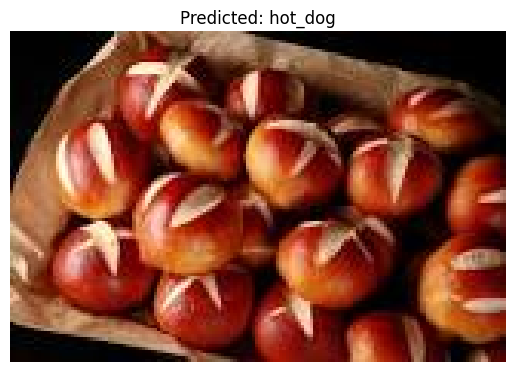

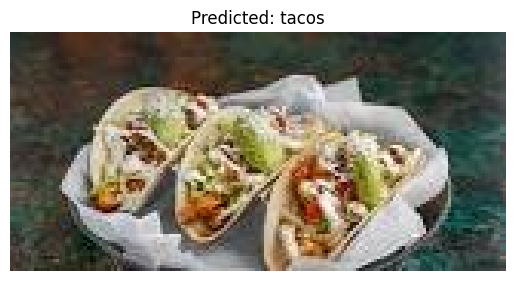

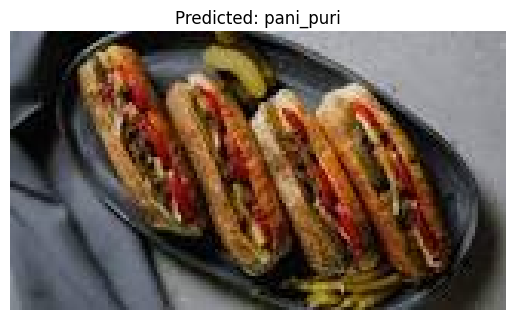

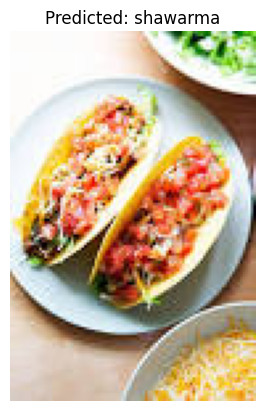

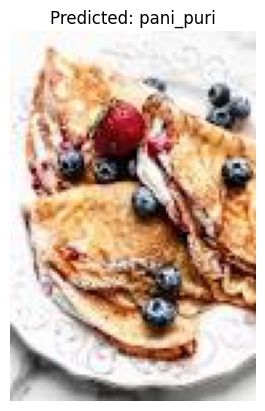

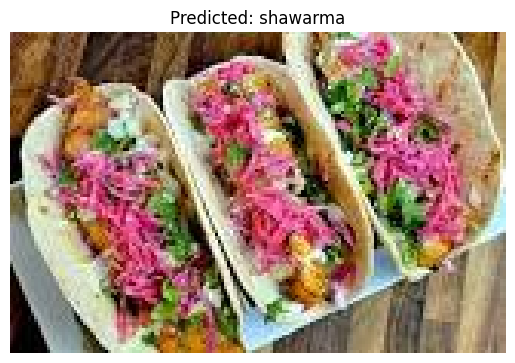

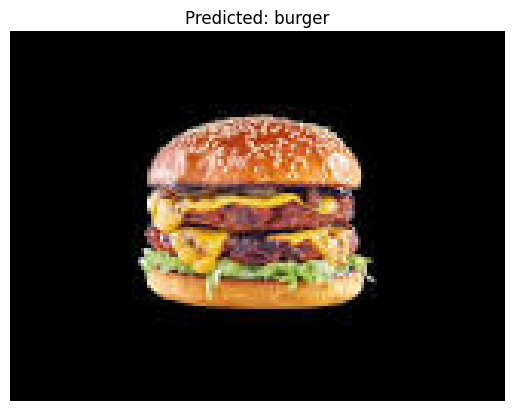

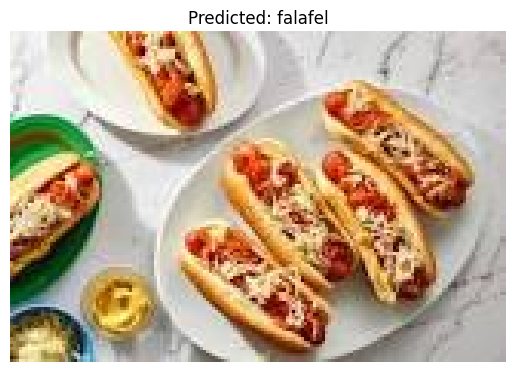

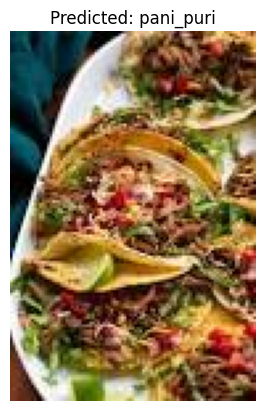

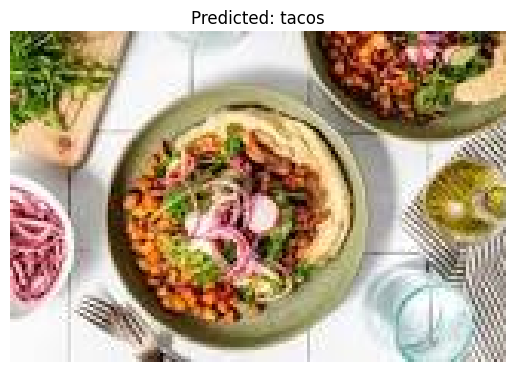

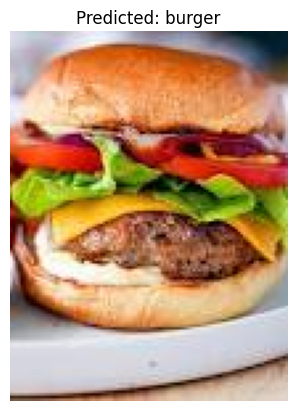

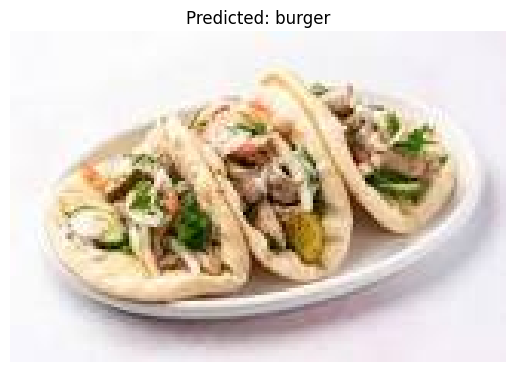

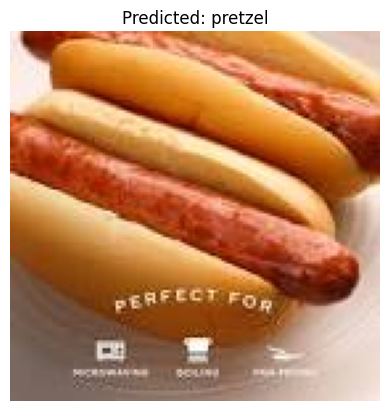

KeyboardInterrupt: 

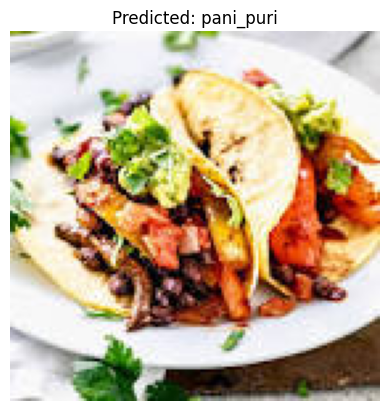

In [36]:
import os
import matplotlib.pyplot as plt
import time 
# Path to folder with random test images
test_path = "../data/test_images"

# Get all image files
test_images = [os.path.join(test_path, f) for f in os.listdir(test_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

# Classes from training dataset
class_names = full_dataset.classes  # Or train_dataset.classes if you have it

# Run predictions and show them
for img_path in test_images:
    img = Image.open(img_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(img_tensor)
        _, predicted = output.max(1)
    
    predicted_class = class_names[predicted.item()]
    
    # Show image with predicted label
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
    time.sleep(1)  # Pause to view each image
    plt.show()